# Try to predict future stock price from just the previous stock price

In [62]:
import numpy as np
import scipy as sci
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from stock2 import getAndProcessFinancialDataJSON, getStockTickers
from stock3 import getAndProcessMultiFinancialDataJSON
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
# Get stock data from the internet

# Get 20 random tickers from NYSE
tickers = getStockTickers(20)
tickers = ["AMD", "GME", "AMC", "TSLA", "ZM", "FLO", "SQ", "GPS", "VTRS", "LNC", "NRG"]

#tickers = ["AMD"]
# get stock data from those tickers
X_raw,y_raw = getAndProcessMultiFinancialDataJSON(tickers,look_fwd=1, interval="2m", rge="1mo")

#X_raw,y_raw = getAndProcessFinancialDataJSON("AMD",look_fwd=2)
print(tickers)
print("Data size: ",len(X_raw))

Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/chart/AMD?interval=2m&range=1mo ]
Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/chart/GME?interval=2m&range=1mo ]
Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/chart/AMC?interval=2m&range=1mo ]
Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/chart/TSLA?interval=2m&range=1mo ]
Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/chart/ZM?interval=2m&range=1mo ]
Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/chart/FLO?interval=2m&range=1mo ]
Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/chart/SQ?interval=2m&range=1mo ]
Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/chart/GPS?interval=2m&range=1mo ]
Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/chart/VTRS?interval=2m&range=1mo ]
Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/char

In [41]:
unix_time = getAndProcessFinancialDataJSON(tickers[0],justTimes=True)
print(unix_time)

Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/chart/AMD?interval=2m&range=1d ]
[1620394200, 1620394320, 1620394440, 1620394560, 1620394680, 1620394800, 1620394920, 1620395040, 1620395160, 1620395280, 1620395400, 1620395520, 1620395640, 1620395760, 1620395880, 1620396000, 1620396120, 1620396240, 1620396360, 1620396480, 1620396600, 1620396720, 1620396840, 1620396960, 1620397080, 1620397200, 1620397320, 1620397440, 1620397560, 1620397680, 1620397800, 1620397920, 1620398040, 1620398160, 1620398280, 1620398400, 1620398520, 1620398640, 1620398760, 1620398880, 1620399000, 1620399120, 1620399240, 1620399360, 1620399480, 1620399600, 1620399720, 1620399840, 1620399960, 1620400080, 1620400200, 1620400320, 1620400440, 1620400560, 1620400680, 1620400800, 1620400920, 1620401040, 1620401160, 1620401280, 1620401400, 1620401520, 1620401640, 1620401760, 1620401880, 1620402000, 1620402120, 1620402240, 1620402360, 1620402480, 1620402600, 1620402720, 1620402840, 1620402960, 162040308

In [3]:
X_raw_numpy = X_raw.to_numpy()
y_raw_numpy = y_raw.to_numpy()

In [4]:
# clean data
delete_list = []
for i in range(len(X_raw_numpy)):
    if(y_raw_numpy[i] == None):
        delete_list.append(i)
    for j in range(len(X_raw_numpy[0])):
        if(X_raw_numpy[i][j] == None):
            delete_list.append(i)
X_clean = np.delete(X_raw_numpy, delete_list, 0)
y_clean = np.delete(y_raw_numpy, delete_list, 0)
# np.isnan(y_raw[i])

print("original size:",len(y_raw))
print("elements to delete:",len(delete_list))
print("resulting size:",len(y_clean))
print("result+delete size:",len(y_clean) + len(delete_list))

original size: 47179
elements to delete: 322
resulting size: 46968
result+delete size: 47290


In [5]:
print(X_clean)
print(y_clean)
print(len(X_clean))
print(len(y_clean))

[[83.1238021850586]
 [82.9000015258789]
 [82.99649810791016]
 ...
 [34.81999969482422]
 [34.83000183105469]
 [34.810001373291016]]
[[-1.0]
 [1.0]
 [-1.0]
 ...
 [1.0]
 [-1.0]
 [-1.0]]
46968
46968


In [6]:
# Split into train, validate, and test sets
size = len(X_clean)

# Get test size and data
total_train_size = (size*8)//10
test_size = size - total_train_size

X_total_train_unnorm = X_clean[:total_train_size]
y_total_train_unnorm = y_clean[:total_train_size]

X_test_unnorm = X_clean[total_train_size:]
y_test_unnorm = y_clean[total_train_size:]

# Get train and validation size and data
train_size = (total_train_size*8)//10
val_size = total_train_size - train_size

X_train_unnorm = X_total_train_unnorm[:train_size]
y_train_unnorm = y_total_train_unnorm[:train_size]

X_val_unnorm = X_total_train_unnorm[train_size:]
y_val_unnorm = y_total_train_unnorm[train_size:]



In [7]:
print(total_train_size)
print(train_size)
print(val_size)
print(test_size)
print()
print(len(X_total_train_unnorm))
print(len(X_train_unnorm))
print(len(X_val_unnorm))
print(len(X_test_unnorm))
print()
print(len(y_total_train_unnorm))
print(len(y_train_unnorm))
print(len(y_val_unnorm))
print(len(y_test_unnorm))

37574
30059
7515
9394

37574
30059
7515
9394

37574
30059
7515
9394


In [8]:
# Scale between 0 and 1, best for LSTM models
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_norm = scaler.fit_transform(X_train_unnorm)
y_train_norm = scaler.fit_transform(y_train_unnorm)

X_val_norm = scaler.fit_transform(X_val_unnorm)
y_val_norm = scaler.fit_transform(y_val_unnorm)

X_test_norm = scaler.fit_transform(X_test_unnorm)
y_test_norm = scaler.fit_transform(y_test_unnorm)

In [9]:
# Let's try transposing y...
y = y_train_norm.transpose()[0]
y_val = y_val_norm.transpose()[0]
y_test = y_test_norm.transpose()[0]

In [10]:
# LSTM also needs to adhere to this shape
X =      np.reshape(X_train_norm, (     X_train_norm.shape[0],  1, X_train_norm.shape[1]))
X_val =  np.reshape(X_val_norm,   (     X_val_norm.shape[0],    1, X_val_norm.shape[1]))
X_test = np.reshape(X_test_norm,  (     X_test_norm.shape[0],   1, X_test_norm.shape[1]))
# y =      np.reshape(y_train_norm, (     y_train_norm.shape[0],  -1, y_train_norm.shape[1]))  # y_train_norm  
# y_val =  np.reshape(y_val_norm,   (     y_val_norm.shape[0],    -1, y_val_norm.shape[1]))    # y_val_norm
# y_test = np.reshape(y_test_norm,  (     y_test_norm.shape[0],   -1, y_test_norm.shape[1]))   # y_test_norm  

In [43]:
# Prints for sanity
print(X[0])
print(y)


print(len(X))
print(len(y))

[[0.09681608]]
[0. 1. 0. ... 1. 0. 0.]
30059
30059


In [75]:
# create the LSTM model
input_shape = (1,  1)
print(input_shape)
model = Sequential()

model.add(LSTM(512, input_shape=input_shape, return_sequences=True,dropout=0.8)) #, return_sequences=True))
# Shape = [# of elements, data per element (1)]
model.add(Dense(128, activation='tanh'))
model.add(Dense(16,  activation='tanh'))
model.add(Dense(8,   activation='relu'))
model.add(Dense(1))
# learning_rate=0.001
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001),metrics=["accuracy"])

model.summary()

# mean square error r2 regularization - use regressions

(1, 1)
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_38 (LSTM)               (None, 1, 512)            1052672   
_________________________________________________________________
dense_109 (Dense)            (None, 1, 128)            65664     
_________________________________________________________________
dense_110 (Dense)            (None, 1, 16)             2064      
_________________________________________________________________
dense_111 (Dense)            (None, 1, 8)              136       
_________________________________________________________________
dense_112 (Dense)            (None, 1, 1)              9         
Total params: 1,120,545
Trainable params: 1,120,545
Non-trainable params: 0
_________________________________________________________________


In [76]:
# Train
history = model.fit(X, y, epochs=100, batch_size=64, verbose=1, validation_data=(X_val, y_val))
print("Done!")

Epoch 1/100
470/470 [==============================] - 4s 6ms/step - loss: 0.8520 - accuracy: 0.4868 - val_loss: 0.6984 - val_accuracy: 0.4387
Epoch 2/100
470/470 [==============================] - 3s 6ms/step - loss: 0.6953 - accuracy: 0.4788 - val_loss: 0.6964 - val_accuracy: 0.4387
Epoch 3/100
470/470 [==============================] - 3s 6ms/step - loss: 0.6960 - accuracy: 0.4856 - val_loss: 0.6963 - val_accuracy: 0.4335
Epoch 4/100
470/470 [==============================] - 3s 6ms/step - loss: 0.6955 - accuracy: 0.4806 - val_loss: 0.6944 - val_accuracy: 0.4387
Epoch 5/100
470/470 [==============================] - 3s 6ms/step - loss: 0.6955 - accuracy: 0.4826 - val_loss: 0.6959 - val_accuracy: 0.4330
Epoch 6/100
470/470 [==============================] - 3s 6ms/step - loss: 0.6944 - accuracy: 0.4820 - val_loss: 0.6937 - val_accuracy: 0.4387
Epoch 7/100
470/470 [==============================] - 3s 6ms/step - loss: 0.6956 - accuracy: 0.4747 - val_loss: 0.6957 - val_accuracy: 0.4387

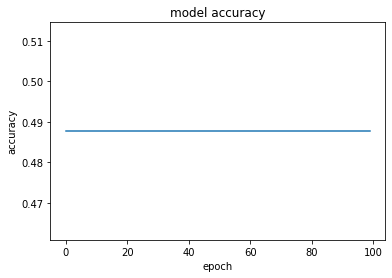

In [51]:
# plot loss and accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()


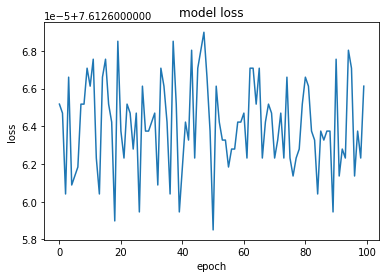

In [52]:
# plot loss and accuracy
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Predict the stock